In [1]:
import numpy as np
import imageio
import matplotlib.pyplot as plt
import cv2
from skimage import color
from scipy import signal
from skimage.restoration import (denoise_tv_chambolle, denoise_bilateral,
                                 denoise_wavelet, estimate_sigma)

#Helpers
import data_loader as dl
import kernel_estimate as ke

In [2]:
def blind_kernel_estimate(Y, X_l, kernel_width, reg_mode=0, reg_weight=1d):
    '''
    Operation: estimate the kernel k that minimizes ||Y-X_l*k||**2 (+ reg_weight * ||k||**2)
    Inputs: 
        2D images Y and X_l (Gray or multichannel)
        kernel_width (integer > 0, better if even)
        reg_mode (0: no reg, 1: L2 reg)
        reg_weight (weight of the L2 reg term, ignored when reg_mode=0)
    Outputs: 
        k of size kernel_width x kernel_width (or kernel_width-1 if it is odd)
    '''
    
    # Convert inputs to Fourier domain
    X_l_Freq = np.fft.fft2(X_l, axes=[0, 1])
    Y_Freq = np.fft.fft2(Y, axes=[0, 1])

    # Solve for k in Fourier domain (regularization only affects den)
    num = X_l_Freq.conjugate() * Y_Freq
    if reg_mode == 0:
        den = np.abs(X_l_Freq)**2 # Fourier transform of X_l transpose * X_l
    elif reg_mode == 1:
        den = reg_weight + np.abs(X_l_Freq)**2 # Fourier transform of [2*reg_weight + X_l transpose * X_l]
    k_l_Freq = num / den

    # Get average channel solution if multi-channel
    if k_l_Freq.ndim == 3:
        k_l_Freq = np.mean(k_l_Freq, 2)
    
    # Convert back to spatial, given the width
    if kernel_width < 1:
        raise ValueError('kernel_width must be a positive integer')
    k_l = otf2psf(k_l_Freq, [kernel_width, kernel_width])

    # Correct the pixel shift for odd width
    if (kernel_width % 2 == 1):
        k_l = k_l[1:,1:]
    
    # Normalize to 1
    k_l = k_l / k_l.sum()
    
    return k_l


In [3]:
def otf2psf(otf, outsize=None):
    insize = np.array(otf.shape)
    psf = np.fft.ifftn(otf, axes=(0, 1))
    for axis, axis_size in enumerate(insize):
        psf = np.roll(psf, np.floor(axis_size / 2).astype(int), axis=axis)
    if type(outsize) != type(None):
        insize = np.array(otf.shape)
        outsize = np.array(outsize)
        n = max(np.size(outsize), np.size(insize))
        # outsize = postpad(outsize(:), n, 1);
        # insize = postpad(insize(:) , n, 1);
        colvec_out = outsize.flatten().reshape((np.size(outsize), 1))
        colvec_in = insize.flatten().reshape((np.size(insize), 1))
        outsize = np.pad(colvec_out, ((0, max(0, n - np.size(colvec_out))), (0, 0)), mode="constant")
        insize = np.pad(colvec_in, ((0, max(0, n - np.size(colvec_in))), (0, 0)), mode="constant")

        pad = (insize - outsize) / 2
        if np.any(pad < 0):
            print("otf2psf error: OUTSIZE must be smaller than or equal than OTF size")
        prepad = np.floor(pad)
        postpad = np.ceil(pad)
        dims_start = prepad.astype(int)
        dims_end = (insize - postpad).astype(int)
        for i in range(len(dims_start.shape)):
            psf = np.take(psf, range(dims_start[i][0], dims_end[i][0]), axis=i)
    n_ops = np.sum(otf.size * np.log2(otf.shape))
    psf = np.real_if_close(psf, tol=n_ops)
    return psf

In [5]:
def estimate_kernel_denoised(patch_sharp,patch_blurred):

    denoised_image = denoise_wavelet(patch_blurred, multichannel=False,rescale_sigma=True)

    kernel_sizes = range(3,30)
    convoluted_images1 = []
    convoluted_images2 = []
    errors_k1 = []
    errors_k2 = []
    kernels1 = []
    kernels2 = []

    for k in kernel_sizes:
        
        k1 =blind_kernel_estimate(denoised_image, patch_sharp, k,1)
        kernels1.append(k1)


        convoluted_image1 = signal.convolve2d(patch_sharp,k1,mode = 'same',boundary = 'wrap')
        convoluted_images1.append(convoluted_image1)

        errors_k1.append( np.mean(np.sqrt((convoluted_image1-patch_blurred)**2)) )

    min_index = np.argmin(errors_k1)
    k_final = kernels1[min_index]
    error_final = errors_k1[min_index]
    return [k_final,error_final,k_final.shape[0]]
    

In [4]:
def estimate_kernel(patch_sharp,patch_blurred, report =False):
    

    #sig_est = estimate_sigma(patch_blurred)
    #noise = np.random.normal(0,sig_est,patch_blurred.shape)
    denoised_image = denoise_wavelet(patch_blurred, multichannel=False,rescale_sigma=True)

    kernel_sizes = range(3,35)
    convoluted_images1 = []
    convoluted_images2 = []
    errors_k1 = []
    errors_k2 = []
    kernels1 = []
    kernels2 = []

    for k in kernel_sizes:
        k1 =blind_kernel_estimate(denoised_image, patch_sharp, k,1)
        k2 = blind_kernel_estimate(patch_blurred, patch_sharp, k,1)

        kernels1.append(k1)
        kernels2.append(k2)

        convoluted_image1 = signal.convolve2d(patch_sharp,k1,mode = 'same',boundary = 'wrap')
        convoluted_images1.append(convoluted_image1)

        convoluted_image2 = signal.convolve2d(patch_sharp,k2,mode = 'same',boundary = 'wrap')
        convoluted_images2.append(convoluted_image2)

        errors_k1.append( np.mean(np.sqrt((convoluted_image1-patch_blurred)**2)) )
        errors_k2.append( np.mean(np.sqrt((convoluted_image2-patch_blurred)**2)) )
        error_k1_sharp = np.mean(np.sqrt((convoluted_image1-patch_sharp)**2))
        error_k2_sharp = np.mean(np.sqrt((convoluted_image2-patch_sharp)**2))

    min_index = np.argmin(errors_k1)
    convoluted_image1 = convoluted_images1[min_index]
    convoluted_image2 = convoluted_images2[min_index]
    k1 = kernels1[min_index]
    k2 = kernels2[min_index]
    error_k1 = errors_k1[min_index]
    error_k2 = errors_k2[min_index]
    
    if report :
        fig , axs = plt.subplots(2,3)
    
        fig.set_figheight(15)
        fig.set_figwidth(15)

        axs[0,0].imshow(sharp_patches[patch_index])
        axs[0,0].set_title('sharp image')

        axs[0,1].imshow(blurred_patches[patch_index])
        axs[0,1].set_title('actual blurred image')

        #axs[2].imshow(denoised_image)
        #axs[2].set_title('denoised blurred image')

        axs[0,2].imshow(convoluted_image1)
        axs[0,2].set_title('estimated blurred image 1')

        axs[1,0].imshow(convoluted_image2)
        axs[1,0].set_title('estimated blurred image 2')

        axs[1,1].imshow(k1)
        axs[1,1].set_title('k1')

        axs[1,2].imshow(k2)
        axs[1,2].set_title('k2')
        #axs[4].imshow(denoised_image-blurred_patches[patch_index])
        #axs[4].imshow(denoised_image-convoluted_image)

        print('error k1 : ' + str(error_k1))
        print('error k2 : ' + str(error_k2))
        print('error k1 to sharp : ' + str(error_k1_sharp))
        print('error k2 to sharp: ' + str(error_k2_sharp))
        print('k1 shape : ' + str(k1.shape))
        print('k2 shape : ' + str(k2.shape))
    



In [6]:
#load images
sharp_image_path = "Data/focused_images/cropped_images/stack1_cropped.jpg"
blurred_image_path = "Data/focused_images/cropped_images/testImages/stack1/image26_registered.png"
sharp_image_raw = cv2.imread(sharp_image_path,cv2.IMREAD_GRAYSCALE)
blurred_image_raw = cv2.imread(blurred_image_path,cv2.IMREAD_GRAYSCALE)

#blurred_image = cv2.normalize(blurred_image_raw,None, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)
#sharp_image = cv2.normalize(sharp_image_raw,None, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)
blurred_image = blurred_image_raw
sharp_image = sharp_image_raw

#sharp_patches = dl.extract_patch(1,64,blurred_image)
patch_shape = [64,64]
x_idxs = range(0,blurred_image.shape[0],patch_shape[0])
y_idxs = range(0,blurred_image.shape[1],patch_shape[1])
blurred_patches = []
sharp_patches= []
for i in range(0,len(x_idxs)-1):
    for j in range(0,len(y_idxs)-1):
        blurred_patch = blurred_image[x_idxs[i]:x_idxs[i+1],y_idxs[j]:y_idxs[j+1]]
        blurred_patches.append(blurred_patch)
        sharp_patch = sharp_image[x_idxs[i]:x_idxs[i+1],y_idxs[j]:y_idxs[j+1]]
        sharp_patches.append(sharp_patch)

        
kernels = []   
errors= []
kernel_shapes = []
for patch_index in range(0,len(sharp_patches)):
    result = estimate_kernel_denoised(sharp_patches[patch_index],blurred_patches[patch_index])
    kernels.append(result[0])
    errors.append(result[1])
    kernel_shapes.append(result[2])

kernels = np.array(kernels)
errors = np.array(errors)
kernel_shapes = np.array(kernel_shapes)

small_kernels = kernels[kernel_shapes <=10]
small_errors = errors[kernel_shapes <=10]

medium_kernels = kernels[np.logical_and(kernel_shapes <=20 , kernel_shapes > 10 )]
medium_errors = errors[np.logical_and(kernel_shapes <=20 , kernel_shapes > 10 )]

large_kernels = kernels[kernel_shapes >20]
large_errors = errors[kernel_shapes >20]



In [7]:
print('number of large kernels : ' + str(len(large_kernels)))
print('number of medium kernels : ' + str(len(medium_kernels)))
print('number of small kernels : ' + str(len(small_kernels)))

number of large kernels : 598
number of medium kernels : 282
number of small kernels : 222


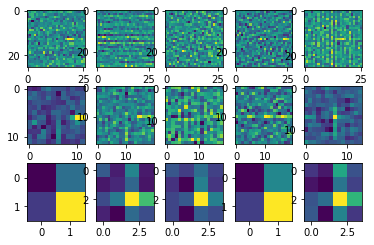

In [8]:
#plt.imshow(medium_kernels[np.argmin(medium_errors)])
sorted_large = large_kernels[np.argsort(large_errors)]
sorted_medium = medium_kernels[np.argsort(medium_errors)]
sorted_small = small_kernels[np.argsort(small_errors)]
fig,axs = plt.subplots(3,5)
for i in range(0,5):
   axs[0,i].imshow(sorted_large[i])
for i in range(0,5):
   axs[1,i].imshow(sorted_medium[i])
for i in range(0,5):
   axs[2,i].imshow(sorted_small[i])


In [9]:
np.save('estimated_kernels2',kernels)


In [10]:
selected_kernels = np.concatenate((sorted_medium[0:5],sorted_large[0:5]))

In [11]:
np.save('selected_kernels2',selected_kernels)

In [14]:
print(np.sort(large_errors)[0:5])

[1.60455069 1.72223096 1.73348726 1.75682151 1.79862531]
